In [1]:
from PyAWD.VectorialAcousticWaveDataset import *
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from time import time
import torch
from torchinfo import summary
torch.manual_seed(0)
sns.set_theme()

In [2]:
device = 'cpu'
torch.set_default_device(device)

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    def __len__(self):
        return len(self.X)

In [4]:
train = torch.load("../../../local/datasets/AWD/train.pt")
X = [torch.Tensor(np.array([train.interrogate(i, inter)+(-0.5+np.random.random((int(10/train.ddt),))*0.002) for inter in train.interrogators])).to(device) for i in range(train.size)]
Y = [torch.Tensor(np.array([train[i][0]/(train.nx/2)])).to(device) for i in range(train.size)]

In [5]:
print(X[0].shape)

torch.Size([2, 2, 1000])


In [6]:
test = torch.load("../../../local/datasets/AWD/test.pt")
X_test = [torch.Tensor(np.array([test.interrogate(i, inter)+(-0.5+np.random.random((int(10/train.ddt),))*0.002) for inter in test.interrogators])).to(device) for i in range(test.size)]
Y_test = [torch.Tensor(np.array([test[i][0]/(test.nx/2)])).to(device) for i in range(test.size)]

In [7]:
train = CustomDataset(X, Y)
train_loader = torch.utils.data.DataLoader(train, batch_size=10)

test = CustomDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=10)

In [8]:
def NMSELoss(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()/np.var(y)

In [9]:
def train_loop(loader, model, loss_fn, optimizer, scheduler):
    model.train()
    for x, y in loader:
        pred = model(x)
        loss = loss_fn(pred.squeeze(1), y.squeeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()

def test_loop(model, loader):
    model.eval()
    loss = 0
    for x, y in loader:
        pred = model(x)
        loss += loss_fn(pred.squeeze(1), y.squeeze(1)).item()
    return loss/len(X)      

In [12]:
class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()

        self.linear1 = torch.nn.Linear(X[0].shape[-1], 250)
        self.activation = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(250, 50)
        self.flatten = torch.nn.Flatten()
        self.linear3 = torch.nn.Linear(np.prod(X[0].shape[:-1])*50, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.flatten(x)
        x = self.linear3(x)
        x = self.activation(x)
        return x

model = FFN()
learning_rate = 5*1e-4
epochs = 1000
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
losses = []

In [13]:
t = time()
for e in tqdm(range(epochs)):
    train_loop(train_loader, model, loss_fn, optimizer, scheduler)
    losses.append(test_loop(model, test_loader))
t = time()-t

  0%|          | 0/1000 [00:00<?, ?it/s]

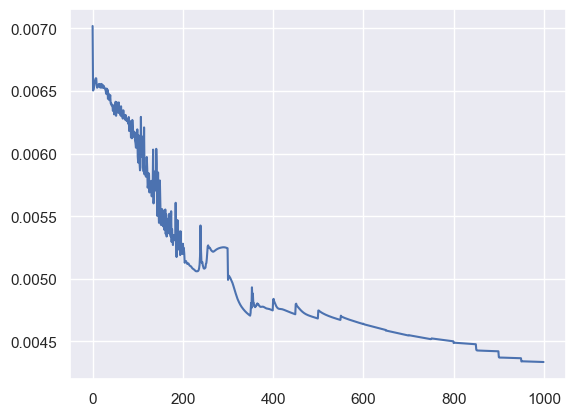

In [14]:
plt.plot(losses)

NMSE: 0.6975181736742132


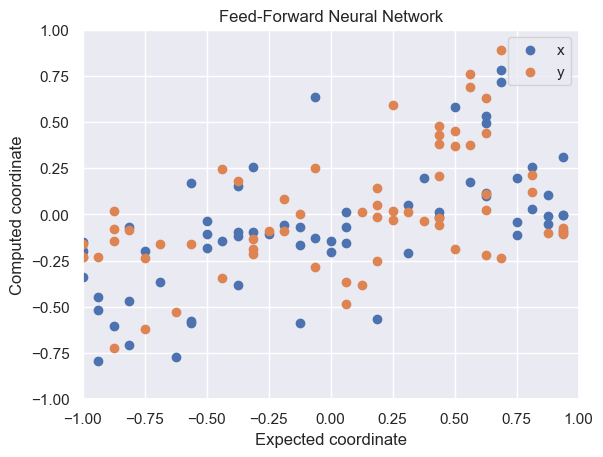

In [15]:
y_test = np.array([(i[:, 0].item(), i[:, 1].item()) for i in Y_test])
y_hat = np.array([model.forward(torch.Tensor(i).unsqueeze(0)).detach().numpy() for i in X_test])
y_hat = np.array([(i[:, 0].item(), i[:, 1].item()) for i in y_hat])
nmse = NMSELoss(y_test, y_hat)
print("NMSE:", nmse)
plt.scatter(y_test[:, 0], y_hat[:, 0])
plt.scatter(y_test[:, 1], y_hat[:, 1])
plt.legend(["x", "y"])
plt.xlabel("Expected coordinate")
plt.ylabel("Computed coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Feed-Forward Neural Network")
plt.savefig("../Results/FFN_noise.jpg", dpi=250)

In [16]:
print("FNN_noise" + " & " + str(nmse)[:7] + " & " + str(t)[:7] + " & " + str(nmse*t)[:7] + "\\\\\n")

FNN_noise & 0.69751 & 35.8402 & 24.9992\\

